In [1]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from astropy.io import fits as fits
from astropy.table import Table
from astropy import constants as const
from astropy import units as u
from astropy.table import QTable

import healpy as hp
import math

import sys
sys.path.append('/global/homes/l/lbigwood/LSS/py')
import LSS
import LSS.SV3
import LSS.SV3.cattools as cattools

from desitarget.sv3.sv3_targetmask import desi_mask, bgs_mask, mws_mask
from desitarget.geomask import get_imaging_maskbits 

nside = 32
orig_density_per_deg = 2500

In [2]:
#number of pixels on sphere and pixel area
npix = hp.nside2npix(nside)
pixel_area = hp.nside2pixarea(nside,degrees=True)

/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/projaxes.py:541: UserWarning: 0.0 180.0 -180.0 180.0
  warnings.warn(
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/projaxes.py:656: UserWarning: The interval between parallels is 20 deg 0.00'.
  warnings.warn(
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/projaxes.py:664: UserWarning: The interval between meridians is 20 deg 0.00'.
  warnings.warn(


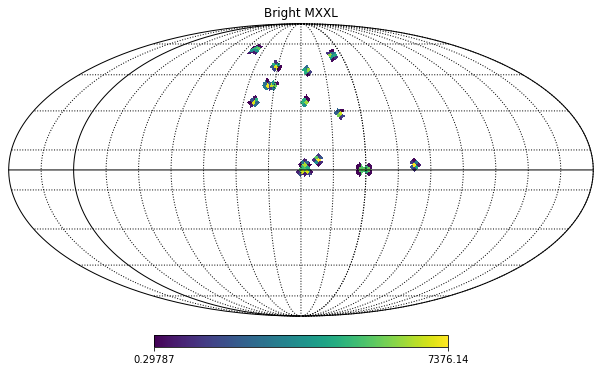

In [3]:
f = fits.open('/global/cscratch1/sd/mjwilson/desi/BGS/lumfn/MXXL/bright_v0.9.fits')
mxxl=f[1].data

# bright_mxxl = Table(mxxl[(mxxl['RMAG_DRED'])<= 19.5])
# faint_mxxl = Table(mxxl[(mxxl['RMAG_DRED'])> 19.5])

theta = np.pi / 2. - np.radians(mxxl['DEC'].data)
phi = np.radians(mxxl['RA'].data)

#indices of pixels with non-zero density, unorganised list.
all_pixel_indices = hp.ang2pix(nside, theta, phi,nest=True, lonlat=False)

#indice of filled pixels and corrosponding targets in pixel
filled_pixel_index, filled_targets_per_pixel = np.unique(all_pixel_indices, return_counts=True) 

#no. targets per pixel, initially 0 
targets_per_pixel = np.zeros(hp.nside2npix(nside))

#update no. targets per pixel 
targets_per_pixel[filled_pixel_index] = filled_targets_per_pixel/pixel_area
targets_per_pixel[targets_per_pixel == 0] = np.NaN 

#mollview map of pixels
hp.mollview(targets_per_pixel,nest=True,rot=(220, 0.0, 0.0), badcolor='white',title='Bright MXXL')
hp.graticule(dpar=5, dmer=5) 

In [4]:
#cut to a single pixel
single_mask = (all_pixel_indices==2286)
single_pixel_mxxl = mxxl[single_mask]

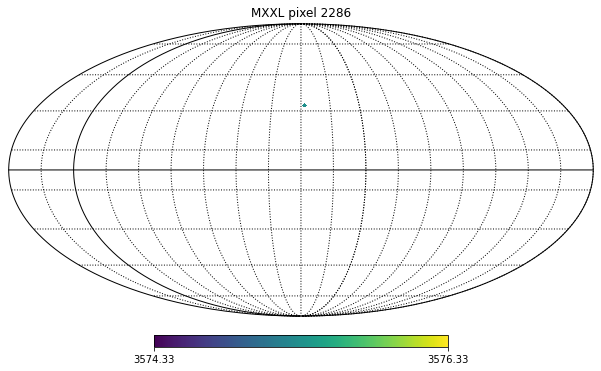

In [5]:
#set coordinates
theta = np.pi / 2. - np.radians(single_pixel_mxxl['DEC'].data)
phi = np.radians(single_pixel_mxxl['RA'].data)

#indices of pixels with non-zero density, unorganised list.
all_pixel_indices = hp.ang2pix(nside, theta, phi,nest=True, lonlat=False)

#indice of filled pixels and corrosponding targets in pixel
filled_pixel_index, filled_targets_per_pixel = np.unique(all_pixel_indices, return_counts=True) 

#no. targets per pixel, initially 0 
targets_per_pixel = np.zeros(hp.nside2npix(nside))

#update no. targets per pixel 
targets_per_pixel[filled_pixel_index] = filled_targets_per_pixel/pixel_area
targets_per_pixel[targets_per_pixel == 0] = np.NaN 

#mollview map of pixels
hp.mollview(targets_per_pixel,nest=True,rot=(220, 0.0, 0.0), badcolor='white',title='MXXL pixel 2286')
hp.graticule(dpar=5, dmer=5) 

In [5]:
#put into astropy table form as easier
single_pixel_mxxl = Table(single_pixel_mxxl)
single_pixel_mxxl

MOCKRA,MOCKDEC,Z,ZOBS,MRH,RMAG_DRED,REFGMR0P1,GTYPE,HMASS,NMOCK,HALOID,RA,DEC,TILEID,ROSETTE,TARGETID
float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,int64,int64,int64
151.7946319580078,32.587886810302734,0.22676359117031097,0.22690549492835999,-19.50278091430664,19.908157348632812,0.4337816536426544,0.0,29.984575271606445,4,518510780,218.25636456601126,32.81813503005441,211,7,2786045
161.65171813964844,33.268436431884766,0.07316961884498596,0.07462241500616074,-19.675804138183594,17.03407859802246,0.5126975178718567,0.0,48.36236572265625,3,347813749,217.7341398481513,33.35300965858068,211,7,2786398
161.69271850585938,32.85031509399414,0.2951381802558899,0.2930662930011749,-20.72875213623047,19.619094848632812,0.97665935754776,0.0,118.66767120361328,3,567467051,218.01461645885885,33.00530329995791,211,7,2786448
161.55142211914062,32.71393585205078,0.2935197055339813,0.2911304533481598,-21.02385711669922,19.17359161376953,0.6787194609642029,0.0,427.1332702636719,3,567444517,217.9704740595073,32.828278153387444,211,7,2786455
162.49090576171875,33.18569564819336,0.05369802936911583,0.05237646400928497,-19.27415657043457,16.71084976196289,0.5662139654159546,0.0,37.85028839111328,3,351574081,218.5161234058684,33.62560878645456,203,7,2786627
151.8583984375,33.0943717956543,0.31909045577049255,0.3193274438381195,-21.376022338867188,19.01789093017578,0.6118157505989075,0.0,106.78179168701172,4,567472373,218.0167053419407,33.2861591244983,211,7,2786688
161.90489196777344,32.63985061645508,0.3393903076648712,0.33908751606941223,-21.143402099609375,19.404537200927734,0.5818796753883362,0.0,267.03582763671875,3,563473101,218.3227086368473,32.90880158153905,211,7,2787125
162.40890502929688,33.75093078613281,0.2521383762359619,0.2529202401638031,-20.42389678955078,19.325252532958984,0.5965592861175537,0.0,100.47611999511719,3,533485157,218.10916444689556,34.083816462583,203,7,2787166
161.42324829101562,33.3052864074707,0.045033182948827744,0.043150462210178375,-19.45867347717285,16.108394622802734,0.7103195786476135,0.0,47.69460678100586,3,676628533,217.51335130976537,33.29139027066707,205,7,2787299


In [7]:
#true/false array for bright/faint objects
single_pixel_mxxl['BGS_BRIGHT'] = single_pixel_mxxl['RMAG_DRED'] <= 19.5

In [8]:
#set subpriorities for all 
single_pixel_mxxl['SUBPRIORITY'] = np.random.uniform(0, 1, len(single_pixel_mxxl))

In [9]:
#set some other headings for all
for x in ['PARALLAX', 'PMRA', 'PMDEC', 'REF_EPOCH']:
    single_pixel_mxxl[x] = 0.0
    

In [10]:
#mask for brights
is_bright =  single_pixel_mxxl['BGS_BRIGHT'] == True


In [11]:
#mask for faints
is_faint =  single_pixel_mxxl['BGS_BRIGHT'] == False


In [12]:
for x in ['PRIORITY', 'PRIORITY_INIT','BGS_TARGET','DESI_TARGET']:
    single_pixel_mxxl[x] = -99

single_pixel_mxxl['PRIORITY_INIT'][is_bright] = 102100
single_pixel_mxxl['PRIORITY'][is_bright] = 102100
single_pixel_mxxl['BGS_TARGET'][is_bright] = 514
single_pixel_mxxl['DESI_TARGET'][is_bright] = 1152921504606846976 

single_pixel_mxxl['PRIORITY_INIT'][is_faint] = 102000
single_pixel_mxxl['PRIORITY'][is_faint] = 102000
single_pixel_mxxl['BGS_TARGET'][is_faint] = 257
single_pixel_mxxl['DESI_TARGET'][is_faint] = 1152921504606846976

In [13]:
#promote the faint higher priority ones i.e 20\% of faints

draws    = np.random.uniform(0, 1, len(single_pixel_mxxl))

is_hip   = (draws > 0.8) & is_faint


single_pixel_mxxl['PRIORITY_INIT'][is_hip] = 102100
single_pixel_mxxl['PRIORITY'][is_hip] = 102100
single_pixel_mxxl['DESI_TARGET'][is_hip] = 1152921504606846976 
single_pixel_mxxl['BGS_TARGET'][is_hip] = 265 

In [14]:
#GET RID OF TARGETIDS!!!!!!!!!!!!!!!!! 

#Working through a list of healpix, create a big for loop at some point 

#total mock catalog 

mtldatamodel = np.array([], dtype=[ 

    ('RA', '>f8'), ('DEC', '>f8'), ('PARALLAX', '>f4'), 

    ('PMRA', '>f4'), ('PMDEC', '>f4'), ('REF_EPOCH', '>f4'), 

    ('DESI_TARGET', '>i8'), ('BGS_TARGET', '>i8'), ('MWS_TARGET', '>i8'), 

    ('SCND_TARGET', '>i8'), ('TARGETID', '>i8'), 

    ('SUBPRIORITY', '>f8'), ('OBSCONDITIONS', 'i4'), 

    ('PRIORITY_INIT', '>i8'), ('NUMOBS_INIT', '>i8'), ('PRIORITY', '>i8'), 

    ('NUMOBS', '>i8'), ('NUMOBS_MORE', '>i8'), ('Z', '>f8'), ('ZWARN', '>i8'), 

    ('TIMESTAMP', 'U25'), ('VERSION', 'U14'), ('TARGET_STATE', 'U30'), 

    ('ZTILEID', '>i4') 

    ]) 

 
t = Table(mtldatamodel) 

# Entries correspond to the datamodel above.  
# RA and DEC are first two entries, need replaced by the mock value.  
# TARGETID needs to start at 0 and increment by 1 with every add row.  
# SUBPRIORITY is a column with values equivalent to np.uniform(0, 1, len(mxxl_healpixel)) 
# PRIORITY_INIT = 102100 for BGS BRIGHT, 102000 FOR BGS FAINT.  
# PRIORITY = PRIORITY_INIT  

#be careful with target ids overlapping for faint and bright targets???
prev_maxtid=0 

for i, row in enumerate(single_pixel_mxxl):
    t.add_row((row['RA'],\
               row['DEC'],\
               row['PARALLAX'],\
               row['PMRA'],\
               row['PMDEC'],\
               row['REF_EPOCH'],\
               row['DESI_TARGET'],\
               row['BGS_TARGET'],\
               0,\
               0,\
               prev_maxtid,\
               row['SUBPRIORITY'],\
               516,\
               row['PRIORITY_INIT'],\
               9,\
               row['PRIORITY'],\
               0,\
               9,\
               -1.0,\
               -1,\
               '2021-04-04T23:05:09',\
               '0.57.0',\
               'BGS|UNOBS',\
               -1))

t.meta['AUTHOR']  = 'Leah Bigwood' 
t.meta['Mock']    = True 
t.meta['MAX_TID'] = t['TARGETID'].data.max()

t.write('/global/cscratch1/sd/lbigwood/S4MOCK/mockledger/sv3/bright/sv3mtl-bright-hp-2286.ecsv' , format='ascii.ecsv', overwrite=True) 

In [15]:
t

RA,DEC,PARALLAX,PMRA,PMDEC,REF_EPOCH,DESI_TARGET,BGS_TARGET,MWS_TARGET,SCND_TARGET,TARGETID,SUBPRIORITY,OBSCONDITIONS,PRIORITY_INIT,NUMOBS_INIT,PRIORITY,NUMOBS,NUMOBS_MORE,Z,ZWARN,TIMESTAMP,VERSION,TARGET_STATE,ZTILEID
float64,float64,float32,float32,float32,float32,int64,int64,int64,int64,int64,float64,int32,int64,int64,int64,int64,int64,float64,int64,str25,str14,str30,int32
218.25636456601126,32.81813503005441,0.0,0.0,0.0,0.0,1152921504606846976,257,0,0,0,0.08747322159653415,516,102000,9,102000,0,9,-1.0,-1,2021-04-04T23:05:09,0.57.0,BGS|UNOBS,-1
217.7341398481513,33.35300965858068,0.0,0.0,0.0,0.0,1152921504606846976,514,0,0,1,0.7824831799983651,516,102100,9,102100,0,9,-1.0,-1,2021-04-04T23:05:09,0.57.0,BGS|UNOBS,-1
218.01461645885885,33.00530329995791,0.0,0.0,0.0,0.0,1152921504606846976,257,0,0,2,0.9748915840819536,516,102000,9,102000,0,9,-1.0,-1,2021-04-04T23:05:09,0.57.0,BGS|UNOBS,-1
217.9704740595073,32.828278153387444,0.0,0.0,0.0,0.0,1152921504606846976,514,0,0,3,0.5790901613299834,516,102100,9,102100,0,9,-1.0,-1,2021-04-04T23:05:09,0.57.0,BGS|UNOBS,-1
218.5161234058684,33.62560878645456,0.0,0.0,0.0,0.0,1152921504606846976,514,0,0,4,0.5929027752950237,516,102100,9,102100,0,9,-1.0,-1,2021-04-04T23:05:09,0.57.0,BGS|UNOBS,-1
218.0167053419407,33.2861591244983,0.0,0.0,0.0,0.0,1152921504606846976,514,0,0,5,0.7382494734599402,516,102100,9,102100,0,9,-1.0,-1,2021-04-04T23:05:09,0.57.0,BGS|UNOBS,-1
218.3227086368473,32.90880158153905,0.0,0.0,0.0,0.0,1152921504606846976,514,0,0,6,0.9070584630617765,516,102100,9,102100,0,9,-1.0,-1,2021-04-04T23:05:09,0.57.0,BGS|UNOBS,-1
218.10916444689556,34.083816462583,0.0,0.0,0.0,0.0,1152921504606846976,514,0,0,7,0.14049537544826696,516,102100,9,102100,0,9,-1.0,-1,2021-04-04T23:05:09,0.57.0,BGS|UNOBS,-1
217.51335130976537,33.29139027066707,0.0,0.0,0.0,0.0,1152921504606846976,514,0,0,8,0.10623852965850844,516,102100,9,102100,0,9,-1.0,-1,2021-04-04T23:05:09,0.57.0,BGS|UNOBS,-1


In [18]:
#seperate bright and faint so can make two different mock catalogs: is it safe to split by priority?
bright_single_pixel_mxxl = single_pixel_mxxl[((single_pixel_mxxl['PRIORITY_INIT']==102100)&(single_pixel_mxxl['BGS_TARGET']==514))]
faint_single_pixel_mxxl = single_pixel_mxxl[((single_pixel_mxxl['PRIORITY_INIT']==102000)&(single_pixel_mxxl['BGS_TARGET']==257))]
hip_single_pixel_mxxl = single_pixel_mxxl[((single_pixel_mxxl['PRIORITY_INIT']==102100)&(single_pixel_mxxl['BGS_TARGET']==265))]

print(len(bright_single_pixel_mxxl)/pixel_area)
print(len(faint_single_pixel_mxxl)/pixel_area)
print(len(hip_single_pixel_mxxl)/pixel_area)

1988.2790838719404
1265.9454841132203
321.10334867624744


In [19]:
print(len(draws[draws>0.8])/len(draws))

0.21053070065816878
